In [9]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scarches.models.scpoli import scPoli

import warnings
from matplotlib import rcParams
FIGSIZE=(2,2)
rcParams['figure.figsize']=FIGSIZE

In [10]:
path_before_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_before_transf.h5ad" 
path_after_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_after_transf.h5ad"

In [11]:
adata_before_correction = sc.read_h5ad(path_before_correction)
adata_after_correction = sc.read_h5ad(path_after_correction)

In [12]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)
compound_names = []

for row in adata_before_correction.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)
    
adata_before_correction.obs["compound"] = compound_names

In [13]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'batch'
cell_type_key = 'compound'

In [16]:
scpoli_model = scPoli(
    adata=adata_before_correction,
    condition_keys=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dims=30,
    recon_loss='mse',
)
scpoli_model.train(
    n_epochs=100,
    pretraining_epochs=10,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

Embedding dictionary:
 	Num conditions: [3]
 	Embedding dim: [30]
Encoder Architecture:
	Input Layer in, out and cond: 384 20 30
	Mean/Var Layer in/out: 20 10
Decoder Architecture:
	First Layer in, out and cond:  10 20 30
	Output Layer in/out:  20 384 

Initializing dataloaders
Starting training
 |██████████----------| 52.0%  - val_loss: 1023.60 - val_cvae_loss:  990.73 - val_prototype_loss:   32.86 - val_labeled_loss:    6.57
ADJUSTED LR
 |█████████████████---| 87.0%  - val_loss: 1035.94 - val_cvae_loss: 1003.56 - val_prototype_loss:   32.38 - val_labeled_loss:    6.48
ADJUSTED LR
 |████████████████████| 100.0%  - val_loss: 1041.46 - val_cvae_loss: 1008.68 - val_prototype_loss:   32.78 - val_labeled_loss:    6.56


In [19]:
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata_before_correction,
    mean=True
)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  c = torch.tensor(label_tensor, device=device).T


In [20]:
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata_before_correction.obs.copy()

In [21]:
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


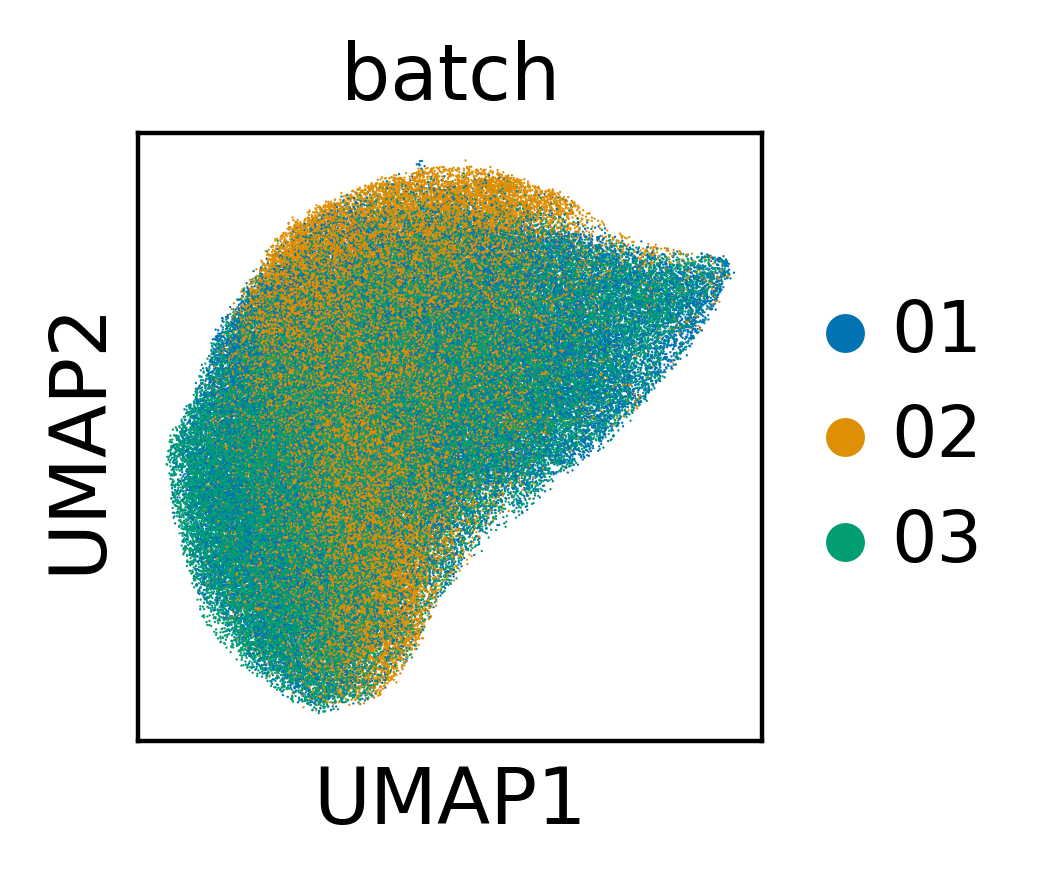

In [42]:
sc.pl.umap(adata_latent, color="batch", palette=sns.color_palette("colorblind"))

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


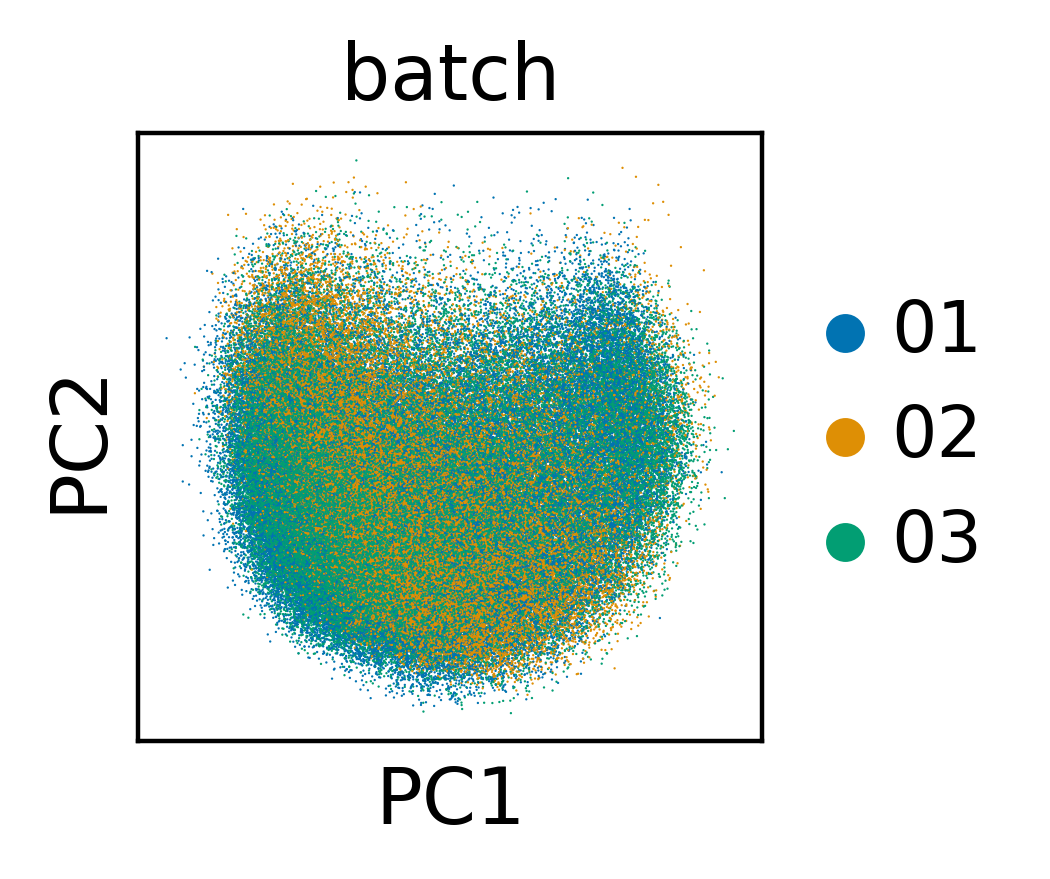

In [43]:
sc.pl.pca(adata_latent, color="batch", palette=sns.color_palette("colorblind"))


In [47]:
adata_scpoli = sc.read_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_scpoli.h5ad")

In [50]:
import torch
torch.cuda.is_available()

False

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


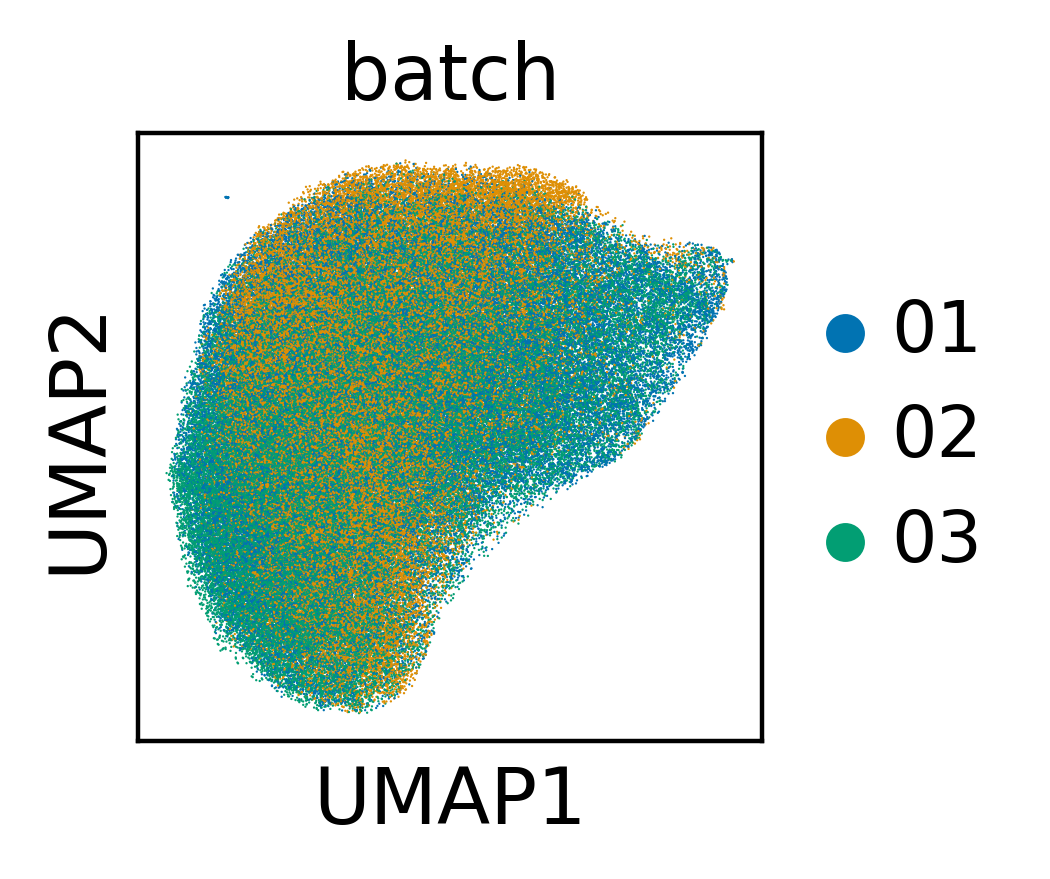

In [48]:
sc.pl.umap(adata_scpoli, color="batch", palette=sns.color_palette("colorblind"))

In [40]:
adata_impa = sc.read_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_before_transf.h5ad")